## <font color='cyan'>Midterm: Deep Learning MCTA 4363</font>
<span style="color:cyan">
    
1) Answer all questions
    
2) This assessment is open-book. You are allowed to refer to any references including online materials, books, notes, codes, github links, chatGPT etc

3) You may train the model in google colab or on your GPU machine directly. 

4) Upload this **answer jupyter notebook in PDF** to the submission link.

    
</span>

**QUESTION 1 [15 marks]**

a) Let *k*, *s* and *p* be 4, 2 and 1, respectively. What will be the shape of the output of the convolutional layer? (2 marks)

>>import torch \
import torch.nn as nn \
input_img = torch.rand(1,3,10,10) \
layer = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=*k*, stride=*s*, padding=*p*)

<span style="color:blue">
    answer: The shape of the output is torch.Size([1, 12, 5, 5])
</span>

b) Batch Normalization (BN) normalizes the mean and standard deviation for each: (tick X for the correct answer(s)) (2 marks)

 - [X] Individual feature map
 - [ ] Instance in the mini-batch
 - [ ] Spatial dimension    

c) Which one of the following is NOT an advantage of Batch Normalization (BN)? (tick X for the correct answer(s)) (2 marks)

- [ ] BN accelerates the training of deep neural networks and tackles the vanishing gradient problem.
- [ ] For every input mini-batch, we calculate different statistics. This introduces some sort of regularization.
- [ ] BN reduces the dependence of gradients on the scale of the parameters or of their initial values.
- [X] BN needs a much slower learning rate for the total architecture to converge.

d) Choose the correct statement. (tick X for the correct answer) (2 marks)

- [X] A larger kernel is preferred for information that resides globally, and a smaller kernel is preferred for information that is distributed locally.
- [ ] A larger kernel is preferred for information that resides locally, and a smaller kernel is preferred for information that is distributed globally.

e) In the following network, how many learnable parameters (weights) are there? (2 marks)

In [ ]:
model = nn.Sequential(
        nn.Linear(3,20),
        nn.ReLU(),
        nn.Linear(20,2)
    )

<span style="color:blue">
    answer: There are 80 (Layer 1) + 0 (ReLU) + 42 (Layer 3) = 122 learnable parameters.
</span>

f) Which of the following statements are true about deep neural networks? (tick X for the correct answer) (2 marks)

- [X] Deep neural networks usually require a big amount of data to be properly trained.
- [X] They can be fooled by adversarial/ noisy examples.
- [X] They are difficult to interpret and understand.
- [X] They can still be subject to biases.
- [ ] They fail to understand the context of the data that they are handling.
- [X] They perform very well on individual tasks but fail to generalize to many different tasks.

g) Run the code in the next cell.

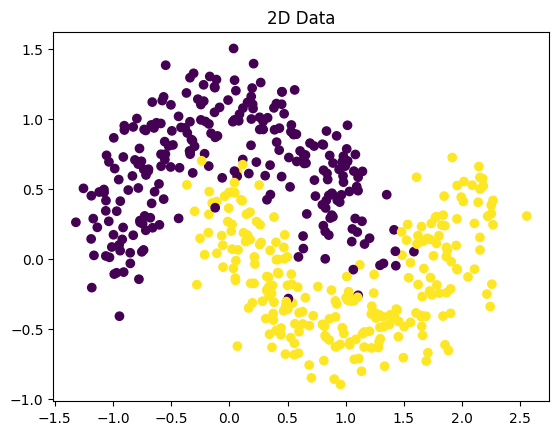

In [1]:
# import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline

# generate synthetic data in 2D
X, Y = make_moons(500, noise=0.2)

# plot the data
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title('2D Data')
plt.show()

Can this data be correctly separable using the classifier below? Why? (3 marks)

model = nn.Sequential( \
    nn.Linear(n_input_dim, n_output), \
    nn.Sigmoid() \
    )
    
<span style="color:blue">
    answer: No, as this data non linearly separable & the model is too simple as it only had simple linear classifier and sigmoid which is insufficient to the model with non linear decision boundary 
</span>

**QUESTION 2 [50 marks]**

To answer the following questions, gather your *own* dataset to solve the image classification problem of distinguishing between individuals wearing and not wearing spectacles as shown in Fig. 1.

![pic](https://i.insider.com/64e53cfd4c17ff0019baa4c0?width=1000&format=jpeg&auto=webp)

           Fig. 1 A person wearing VS not wearing a spectable.

a) Define the *dataloader* to load the train and test datasets. The datasets should be loaded without any data augmentation. Show the code in the following cell. **(5 marks)**

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None, extensions={".jpg", ".jpeg", ".png"}):
        self.image_paths = [
            path for ext in extensions 
            for path in pathlib.Path(image_dir).rglob(f"*{ext}")
        ]
        self.transform = transform

        # Get all class names from folder names
        class_names = sorted({path.parent.name for path in self.image_paths})
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        print(f"📸 Found {len(self.image_paths)} images across {len(self.class_to_idx)} classes.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")  # ensure consistent 3-channel RGB

        # Get label from folder name
        label_name = image_path.parent.name
        label = self.class_to_idx[label_name]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

# Define transformations
data_transform = transforms.Compose(
    [transforms.Resize((256,256)), 
     transforms.ToTensor(),
])

train_data_custom = CustomDataset(image_dir=train_dir, transform=data_transform) # type: ignore
test_data_custom = CustomDataset(image_dir=test_dir, transform=data_transform) # type: ignore

num_workers = (os.cpu_count() or 2) // 2

train_loader = DataLoader(
    dataset=train_data,
    batch_size=128,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=128,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

b) Define a ConvNet corresponding to the following architecture in Fig. 2 (with modifications of the input and final layers). Make sure the number of layers, types of layers, the kernel size, number of feature maps, etc follow exactly the ConvNet as in the figure. **(10 marks)**

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/LeNet.png)
    
                Fig. 2: A convolutional neural network

In [ ]:
class GlassesNetRGB(nn.Module):
    def __init__(self):
        super(GlassesNetRGB, self).__init__()
        
        # C1: Conv layer (5x5 kernel), from 3 input channels (RGB) to 6 feature maps
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)  # 256 -> 252

        # S2: Subsampling: Avg pooling (2x2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # 252 -> 126

        # C3: Conv layer (5x5), from 6 to 16 feature maps
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)  # 126 -> 122

        # S4: Subsampling: Avg pooling (2x2)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # 122 -> 61

        # Feature maps now: 16 x 61 x 61
        self.fc1 = nn.Linear(16 * 61 * 61, 120)  # F5
        self.fc2 = nn.Linear(120, 84)           # F6
        self.output = nn.Linear(84, 2)          # Binary output

    def forward(self, x):
            x = F.relu(self.conv1(x))
            x = self.pool1(x)

            x = F.relu(self.conv2(x))
            x = self.pool2(x)

            x = x.view(x.size(0), -1)

            x = F.relu(self.fc1(x))
            x = self.dropout1(x)

            x = F.relu(self.fc2(x))
            x = self.dropout2(x)

            x = self.output(x)
            return x

  c) Define your training loop and train the ConvNet. **(5 marks)**
  



In [ ]:

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    scaler = GradScaler()  # AMP scaler for mixed precision training
    start_time = time.time()
    model = model.to(device)
    best_acc = 0.0
    best_model_state = deepcopy(model.state_dict())
    history = []

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")

        # TRAIN with AMP scaler
        train_loss, train_acc = run_epoch(model, train_dataloader, loss_criterion, optimizer, device, train=True, scaler=scaler)

        # VALIDATION without optimizer and no grad scaling needed
        val_loss, val_acc = run_epoch(model, test_dataloader, loss_criterion, device=device, train=False, scaler=None)

        history.append([train_loss, val_loss, train_acc, val_acc])

        print(f"Epoch {epoch+1:03d} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}% | "
              f"Time: {time.time() - epoch_start:.2f}s")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = deepcopy(model.state_dict())
            torch.save(model, 'best_model_Glasses.pt')

    model.load_state_dict(best_model_state)
    total_time = time.time() - start_time
    print(f"\nTraining complete in {total_time:.2f}s. Best Validation Accuracy: {best_acc*100:.2f}%")
    return model, history


def run_epoch(model, dataloader, loss_criterion, optimizer=None, device='cuda', train=True, scaler=None):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        if train and optimizer is not None:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            # AMP autocast context — float16 precision for forward pass
            with autocast(device_type='cuda', enabled=(scaler is not None)): 
                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                preds = torch.argmax(outputs, dim=1)

            if train and optimizer is not None:
                if scaler is not None:
                    # scale loss, backward, optimizer step, update scaler
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        correct += (preds == labels).sum().item()
        total += inputs.size(0)

    avg_loss = total_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc


d) Define your loss function and optimizer. Use ADAM as your optimizer with a suitable learning rate. (4 marks) 

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

d) Display the loss and accuracy curves of the training and testing phases. **(4 marks)**

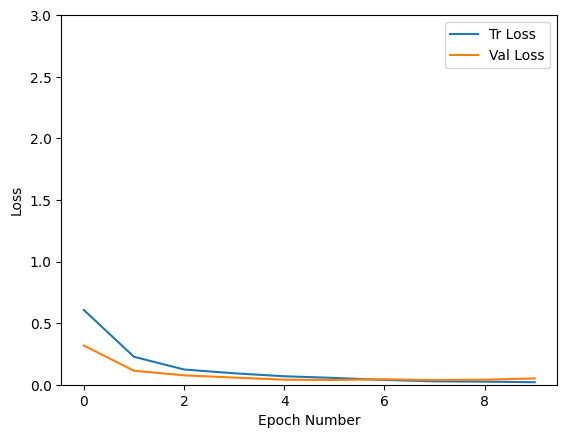

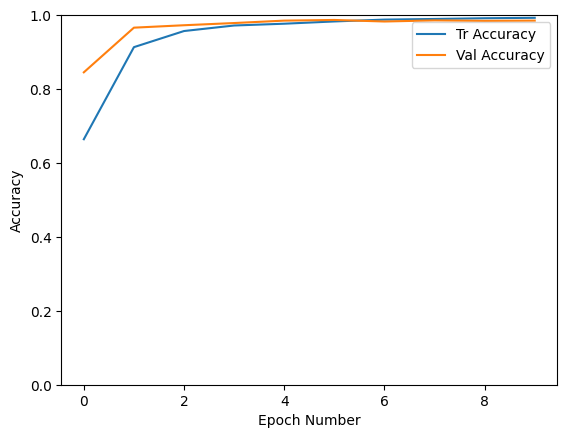

e) Based on Question 2 d), answer the following questions:
    
    i) Propose two methods to reduce the effect of overfitting. (4 marks)
   <font color='blue'>Two methods that I propose are: (1) Regularization (2) Early Stopping</font>
   
    ii) Implement the two proposed methods in Q2 e) ii) in the next cell and show that the overfitting has been reduced. (8 marks)

Epoch 1, Train Loss: 0.6948, Val Loss: 0.6903
Epoch 2, Train Loss: 0.6831, Val Loss: 0.6896
Epoch 3, Train Loss: 0.6755, Val Loss: 0.6857
Epoch 4, Train Loss: 0.6679, Val Loss: 0.6901
Epoch 5, Train Loss: 0.6567, Val Loss: 0.6836
Epoch 6, Train Loss: 0.6482, Val Loss: 0.6922
Epoch 7, Train Loss: 0.6316, Val Loss: 0.6952
Epoch 8, Train Loss: 0.6187, Val Loss: 0.7024
Epoch 9, Train Loss: 0.6013, Val Loss: 0.7200
Epoch 10, Train Loss: 0.5809, Val Loss: 0.7317
Early stopping triggered.


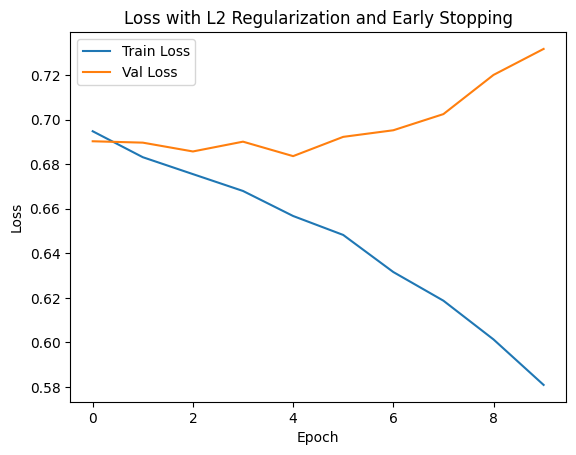

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# Example data (replace with your own)
X = torch.randn(1000, 20)
y = torch.randint(0, 2, (1000,)).float()

# Create dataset and split
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

# Define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(20, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.out(x))
        return x

model = Net()

# Loss and optimizer with L2 regularization (weight_decay)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # L2 regularization

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
counter = 0

train_losses = []
val_losses = []

# Training loop with early stopping
for epoch in range(100):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            outputs = model(val_X).squeeze()
            loss = criterion(outputs, val_y)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(best_model_state)

# Plot loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss with L2 Regularization and Early Stopping')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


c) Replace your defined ConvNet in b) with a **lightweight** pretrained model. Then, proceed with a transfer learning and finetune the model for the spectacle/ no-spectacle dataset. **(10 marks)**

In [ ]:
# Load model with updated syntax
weights = ResNet18_Weights.DEFAULT
model_Pre = resnet18(weights=weights)

for param in model_Pre.parameters():
    param.requires_grad = False

# Unfreeze only the final layer
for param in model_Pre.fc.parameters():
    param.requires_grad = True

# Adjust the final layer for 2 output classes
num_ftrs = model_Pre.fc.in_features
model_Pre.fc = nn.Linear(num_ftrs, 2)

# Loss and optimizer
loss_fn_Pre = nn.CrossEntropyLoss()
optimizer_Pre = torch.optim.SGD(model_Pre.parameters(), lr=0.001, momentum=0.9)

# Move model to GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_Pre.to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

**QUESTION 3** **[15 marks]**

Once you have trained the model with your custom dataset, download the model to your local machine. Next, execute the model inference in VSCode/ pycharm to directly determine if a person is wearing glasses or not. Capture a video of the model in action during the inference process (eg. [LINK](https://drive.google.com/file/d/1SYEAzuHk9DAHsTZFrWyTLgyEZ-4GxRCj/view?usp=sharing)). Upload this video in your gdrive. Please submit the link to this video as the required deliverable for this task.

https://drive.google.com/drive/folders/1uNYdi2bXw4DxgO-jDZw-uH-8BnaD5v3c?usp=drive_link


# For ConvNet

In [ ]:
import cv2
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image

class GlassesNetRGB(nn.Module):
    def __init__(self):
        super(GlassesNetRGB, self).__init__()
        
        # C1: Conv layer (5x5 kernel), from 3 input channels (RGB) to 6 feature maps
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)  # 256 -> 252

        # S2: Subsampling: Avg pooling (2x2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # 252 -> 126

        # C3: Conv layer (5x5), from 6 to 16 feature maps
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)  # 126 -> 122

        # S4: Subsampling: Avg pooling (2x2)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # 122 -> 61

        # Feature maps now: 16 x 61 x 61
        self.fc1 = nn.Linear(16 * 61 * 61, 120)  # F5
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(120, 84)           # F6
        self.dropout2 = nn.Dropout(p=0.5)
        self.output = nn.Linear(84, 2)          # Binary output

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = self.output(x)
        return x

# Load model
model = torch.load('Deep_Learning/Midterm/best_model_Glasses.pt', map_location='cpu')
model.eval()
model.eval()
model.to('cpu')

# Class labels
class_labels = ['Glasses', 'Plain']

# Transformations
data_transform = transforms.Compose(
    [transforms.Resize((256,256)), 
     transforms.ColorJitter(brightness=0.2, contrast=0.2, hue=0.1),  # Light jitter
     transforms.ToTensor(),
])

# Open webcam
capture = cv2.VideoCapture(0)

while True:
    isTrue, frame = capture.read()
    if not isTrue:
        break

    image = frame.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image) 
    image = data_transform(image)  # transform already returns a tensor
    image = image.unsqueeze(0)  # type: ignore # Add batch dimension

    # Inference
    with torch.no_grad():
        output = model(image)
        probs = F.softmax(output, dim=1)  # Convert logits to probabilities

    prob_value, predicted_class = torch.max(probs, dim=1)
    predicted_class = predicted_class.item()
    prob_value = prob_value.item()

    predicted_class_name = class_labels[predicted_class] # type: ignore
    label_text = f"{predicted_class_name} ({prob_value*100:.2f}%)"
    print(label_text)

    # Display on frame
    cv2.putText(frame, label_text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
    cv2.imshow('Gender Classification', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

capture.release()
cv2.destroyAllWindows()


# For ResNet18

In [ ]:
import cv2
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F

# Load model
model = torch.load('Deep_Learning/Midterm/best_model_Glasses_ResNet18.pt')
model.eval()
model.to('cpu')

# Class labels
class_labels = ['Glasses', 'Plain']

# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.RandomHorizontalFlip(p=0.5),  
    #transforms.RandomRotation(degrees=15), 
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, hue=0.1),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Open webcam
capture = cv2.VideoCapture(0)

while True:
    isTrue, frame = capture.read()
    if not isTrue:
        break

    image = frame.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image)  # transform already returns a tensor
    image = image.unsqueeze(0)  # type: ignore # Add batch dimension

    # Inference
    with torch.no_grad():
        output = model(image)
        probs = F.softmax(output, dim=1)  # Convert logits to probabilities

    prob_value, predicted_class = torch.max(probs, dim=1)
    predicted_class = predicted_class.item()
    prob_value = prob_value.item()

    predicted_class_name = class_labels[predicted_class] # type: ignore
    label_text = f"{predicted_class_name} ({prob_value*100:.2f}%)"
    print(label_text)

    # Display on frame
    cv2.putText(frame, label_text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
    cv2.imshow('Gender Classification', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

capture.release()
cv2.destroyAllWindows()
